# Data-driven modeling of a Resistance-Capacitance network with Neural ODEs

This tutorial performs the data-driven modeling of a network of capacitive agents that are coupled by resistive connections.


**Energy balance in dissipative systems**

In many physical systems, behaviors over time are driven by input-output energy balances as prescribed by the [First Law of Thermodynamics](https://en.wikipedia.org/wiki/First_law_of_thermodynamics); i.e.:
$$
\Delta U = Q - W,
$$
where $U$ is internal energy, $Q$ is heat added to the system, and $W$ is work done by the system on it surroundings. This energy accounting scheme can be extended to many situations. For example, suppose we wish to track the temperature ($T$) of a system with some thermal capacity ($C$) through time ($t$). After recasting internal energy as $U = C \cdot T$, this yields a time-dependent form of the First Law of Thermodynamics:
$$
\frac{dT}{dt} = \frac{1}{C}\left( \dot{Q} - \dot{W} \right),
$$
with the heating and work terms now in units of power. This provides a compact framework for analysis of the time dynamics of systems that interact with their surroundings through heating and/or mechanical work. 

Here, we're concerned with systems comprised of many interacting *capacitive agents* - that is, a network of agents with a First Law of Thermodynamics input/output energy balance. This is the foundation for many engineering applications, such as building thermal dynamics. Each closed volume in a building has some thermal capacitance and is coupled via heat flows - through walls, heating, ventilation, air conditioning, etc. - with other capacitive agents. The couplings between capacitive agents are analogous to resistors in a circuit, acting to dissipate power across its connection points. An isolated capacitive agent subject to resistive energy transfer forms a [resistance-capacitance ciruit, or *RC Ciruit*](https://en.wikipedia.org/wiki/RC_circuit). Many coupled agents form a *RC Network*.

A resistively-driven single zone RC agent obeys the First Law energy balance as:
$$
\frac{dT}{dt} = \frac{1}{C} \left( \frac{1}{R}\left( T_{ext} - T \right) \right),
$$
where $T_{ext}$ is the forcing temperature. Note that no work is performed by the system on its surroundings. In the networked setting, the resistive couplings are summed over all of the connections for each agent in the network:
$$
\frac{dT_i}{dt} = \frac{1}{C_i} \left( A_{i,j} \sum_j^n  \frac{1}{R_{i,j}} \left( T_j - T_i \right)  \right),
$$
where $n$ is the number of agents in the network, $i,j \in \{1, 2, \dots , n\}$,  $A_{i,j}$ is the $(0,1)$-*adjacency matrix* defining the network structure (pairwise connections), and $R_{i,j}$ is the resistance for the pairwise interaction.


**Modeling with NeruoMANCER**

Our task is to leverage the known structure of RC networks to estimate capacitances and coupling resistivities from data. We will use the NeruoMANCER package for this task; let's do our imports:

In [9]:
# Numpy + plotting utilities + ordered dicts
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict


# Standard PyTorch imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Neuromancer imports
from neuromancer.psl.coupled_systems import *
from neuromancer.dynamics import integrators, ode, physics, interpolation
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.problem import Problem
from neuromancer.loss import PenaltyLoss
from neuromancer.system import Node, System
from neuromancer.loggers import BasicLogger
from neuromancer.trainer import Trainer

# Fix seeds for reproducibility
np.random.seed(200)
torch.manual_seed(0)


**Data Generation**

Let's generate some data from a 5-zone RC network using NeuroMANCER's built-in RC-Network simulator. First we define a graph structure for our RC network as an array of pairwise connections and then hand this to PSL's RC Network class. A notional diagram of the network is shown below: 5 agents are coupled in a network, all five are connected to an outdoor temperature and a unique heating source.

![RC-Net diagram](figs/rc_net.png)
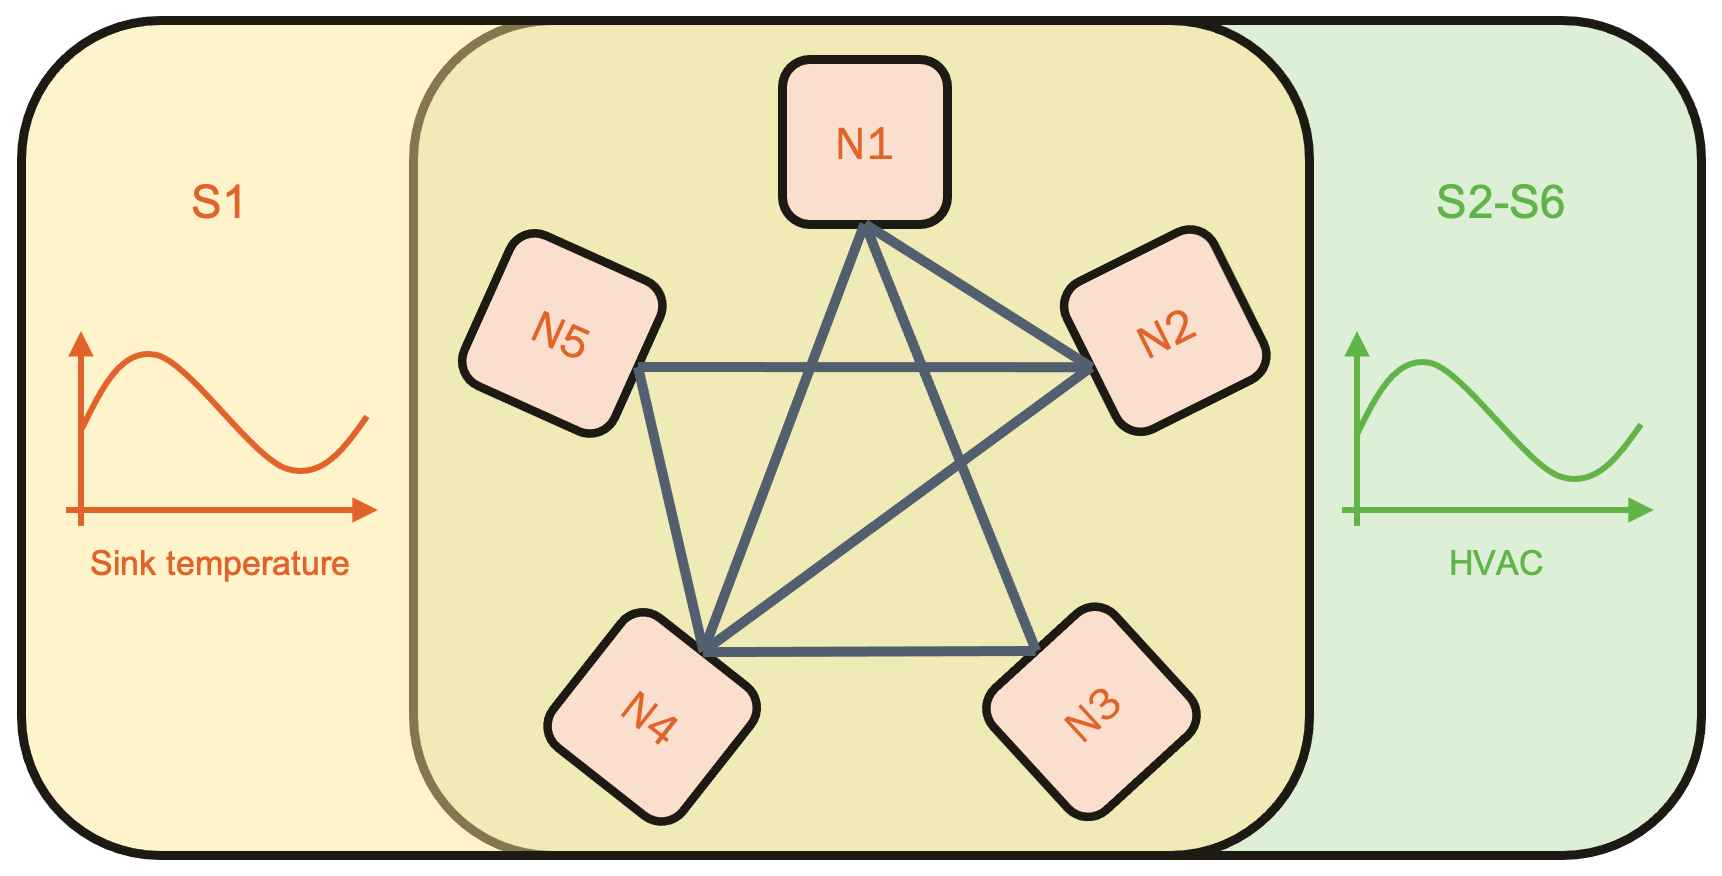

In [10]:
adj = np.array([[0,1],[0,2],[0,3],[1,0],[1,3],[1,4],[2,0],[2,3],[3,0],[3,1],[3,2],[3,4],[4,1],[4,3]]).T
s = RC_Network(nx=5, adj=adj)
nsim = 500
sim, s_dev, s_test = [s.simulate(nsim=nsim) for _ in range(3)]


We can quickly take a look at the evolution of zonal temperatures over the length of the timeseries:

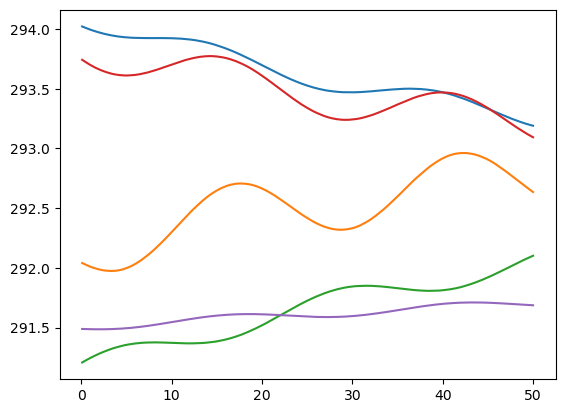

In [11]:
plt.plot(sim['Time'],sim['X'])

And also the external inputs to the system:

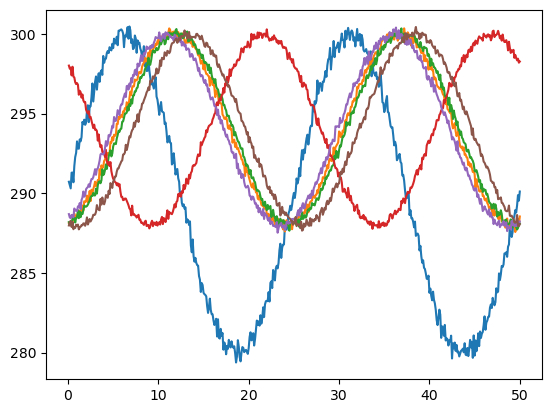

In [12]:
plt.plot(sim['Time'],sim['U'])

Datasets are handled by PyTorch DataLoaders viw DictDatasets:

In [13]:
nstep = 10

train_data = {'Y': sim['Y'], 'X': sim['X'], 'U': sim['U']}
dev_data = {'Y': s_dev['Y'], 'X': s_dev['X'], 'U': s_dev['U']}
test_data = {'Y': s_test['Y'], 'X': s_test['X'], 'U': s_test['U']}
for d in [train_data, dev_data]:
    d['X'] = d['X'].reshape(nsim//nstep, nstep, 5)
    d['Y'] = d['Y'].reshape(nsim//nstep, nstep, 5)
    d['U'] = d['U'].reshape(nsim//nstep, nstep, 6)
    d['xn'] = d['X'][:, 0:1, :]

train_dataset, dev_dataset, = [DictDataset(d, name=n) for d, n in zip([train_data, dev_data], ['train', 'dev'])]
train_loader, dev_loader, test_loader = [DataLoader(d, batch_size=nsim//nstep, collate_fn=d.collate_fn, shuffle=True) for d in [train_dataset, dev_dataset, dev_dataset]]


# Model Construction

Now that we have our data ready to go, let's construct our model for the RC Network system. We have many options for modeling such systems ranging from completely data-driven methods (like Dynamic Mode Decomposition), to data-driven equation-based methods (like Neural ODEs or Sparse Identification of Nonlinear Dynamics). Here, we wish to leverage the known structure of the system to construct a parameter-tuning problem in NeuroMANCER. To that end, we need to create our 5-zone ``building'' and all of the resistive connections that make up the network.


**Agents** 

At the core of a networked dynamical system, we define *agents* as objects possessing a dynamical state that evolves according to an Ordinary Differential Equation (ODE). These can be rooms in a building, a drone in a swarm, etc. In this case, we wish to create five capacitive agents to represent our building from our dataset. Here, we define the zones to be a list of 5 `RCNode`, each with a trainable parameter $C$ - the capacitance for the agent, and a scaling factor. This scaling factor is useful for including if you have prior knowledge of the approximate time constant for the agent.

In [14]:
zones = [physics.RCNode(C=nn.Parameter(torch.tensor(5.0)),scaling=1.0e-5) for i in range(5)]  # heterogeneous population w/ identical physics

Each zone in this network has its own heater. We include these heaters in the model via a `SourceSink` node - essentially a placeholder object for connecting our zones to external inputs.

In [15]:
heaters = [physics.SourceSink() for i in range(5)] # define heaters

Lastly, each zone is also in contact with the ambient environment (the outdoors). We represent outside as an additional `SourceSink` agent and then concatenate these lists:

In [16]:
outside = [physics.SourceSink()]  

# join lists:
agents = zones + heaters + outside

Before we connect our agents together in a graph, we need to define a mapping between our agents in the list and the indices of their respective states in the dataset. For this, we use a quick helper function:

In [17]:
map = physics.map_from_agents(agents)
# Let's take a look at this 'map':
print(map)

[OrderedDict([('T', 0)]), OrderedDict([('T', 1)]), OrderedDict([('T', 2)]), OrderedDict([('T', 3)]), OrderedDict([('T', 4)]), OrderedDict([('T', 5)]), OrderedDict([('T', 6)]), OrderedDict([('T', 7)]), OrderedDict([('T', 8)]), OrderedDict([('T', 9)]), OrderedDict([('T', 10)])]


**Couplings**

From our instantiation of the PSL RC-Network, we already have an adjacency list corresponding to the connections among the 5 zones in our building. To avoid the tedium of individually constructing resistive connections between these agents, let's use a helper function to do it for us:

In [18]:
# Helper function for constructing couplings based on desired edge physics and an edge list:
def generate_parameterized_edges(physics,edge_list):
    """
    Quick helper function to construct edge physics/objects from adj. list:
    """

    couplings = []
    if isinstance(physics,nn.Module): # is "physics" an instance or a class?
        # If we're in here, we expect one instance of "physics" for all edges in edge_list (homogeneous edges)
        physics.pins = edge_list
        couplings.append(physics)
        print(f'Broadcasting {physics} to all elements in edge list.')
    else: 
        # If we're in here, we expect different "physics" for each edge in edge_list (heterogeneous edges)
        for edge in edge_list:
            agent = physics(R=nn.Parameter(torch.tensor(50.0)),pins=[edge])
            couplings.append(agent)

        print(f'Assuming new {physics} for each element in edge list.')

    return couplings

couplings = generate_parameterized_edges(physics.DeltaTemp,list(adj.T))    # Heterogeneous edges of same physics

# What do we have so far?
print(len(couplings))
# Let's take a look at one:
print(couplings[0])
# What's it connecting?
print(couplings[0].pins)


Assuming new <class 'neuromancer.dynamics.physics.DeltaTemp'> for each element in edge list.
14
DeltaTemp()
[array([0, 1])]


Next, we need to add connections between our `SourceSink` agents (the outdoors and the heaters) and the `RCNode` agents with more `DeltaTemp` resistive connections. These are easier to bookkeep, so let's do it manually. Here, the pins argument is expecting a list of arrays that specify pairwise interactions in the format (sender, receiver). Be sure that this order is consistent, especially when defining custom agents and couplings.

In [19]:
# Couple w/ outside temp:
couplings.append(physics.DeltaTemp(R=nn.Parameter(torch.tensor(50.0)),pins=[[0,5]]))
couplings.append(physics.DeltaTemp(R=nn.Parameter(torch.tensor(50.0)),pins=[[1,5]]))
couplings.append(physics.DeltaTemp(R=nn.Parameter(torch.tensor(50.0)),pins=[[2,5]]))
couplings.append(physics.DeltaTemp(R=nn.Parameter(torch.tensor(50.0)),pins=[[3,5]]))
couplings.append(physics.DeltaTemp(R=nn.Parameter(torch.tensor(50.0)),pins=[[4,5]]))

# Couple w/ individual sources:
couplings.append(physics.DeltaTemp(R=nn.Parameter(torch.tensor(50.0)),pins=[[0,6]]))
couplings.append(physics.DeltaTemp(R=nn.Parameter(torch.tensor(50.0)),pins=[[1,7]]))
couplings.append(physics.DeltaTemp(R=nn.Parameter(torch.tensor(50.0)),pins=[[2,8]]))
couplings.append(physics.DeltaTemp(R=nn.Parameter(torch.tensor(50.0)),pins=[[3,9]]))
couplings.append(physics.DeltaTemp(R=nn.Parameter(torch.tensor(50.0)),pins=[[4,10]]))

We're ready to define our ODE System, integrator, and dynamics model:

In [20]:
model_ode = ode.GeneralNetworkedODE(
    map = map,
    agents = agents,
    couplings = couplings,
    insize = s.nx+s.nu,
    outsize = s.nx,
    inductive_bias="compositional")

fx_int = integrators.RK2(model_ode, interp_u = lambda tq, t, u: u, h=1.0)

dynamics_model = System([Node(fx_int,['xn','U'],['xn'])])

**Loss and problem definitions**

We define our loss to be a simple Mean-Squared Error between the reference trajectories ($X^{j}(t)$) and model trajectories ($\hat{X}^{j}(t)$) evaluated at the collocation points $i$ for each $j$-batch:
$$
\mathcal{L} = \frac{1}{N_i \cdot N_k} \left( \sum_i \sum_j \left( X^{j}(t_i) - \hat{X}^{j}(t_i) \right)^2\right)
$$

In [21]:
x = variable("X")
xhat = variable("xn")[:, :-1, :]

reference_loss = ((xhat == x)^2)
reference_loss.name = "ref_loss"

objectives = [reference_loss]
constraints = []

# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)

# construct constrained optimization problem
problem = Problem([dynamics_model], loss)

optimizer = torch.optim.Adam(problem.parameters(), lr=0.01)
logger = BasicLogger(args=None, savedir='test', verbosity=1,
                     stdout=["dev_loss","train_loss"])

trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_data,
    optimizer,
    epochs=1000,
    patience=20,
    warmup=5,
    eval_metric="dev_loss",
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="dev_loss",
    logger=logger,
)

None
Number of parameters: 29


**Training**

In [22]:
best_model = trainer.train()

epoch: 0	train_loss: 0.01284	dev_loss: 0.05561	eltime:  0.34469
epoch: 1	train_loss: 0.01278	dev_loss: 0.05536	eltime:  0.61776
epoch: 2	train_loss: 0.01272	dev_loss: 0.05510	eltime:  0.86013
epoch: 3	train_loss: 0.01266	dev_loss: 0.05485	eltime:  1.10335
epoch: 4	train_loss: 0.01260	dev_loss: 0.05460	eltime:  1.33952
epoch: 5	train_loss: 0.01254	dev_loss: 0.05435	eltime:  1.56498
epoch: 6	train_loss: 0.01248	dev_loss: 0.05410	eltime:  1.79964
epoch: 7	train_loss: 0.01242	dev_loss: 0.05385	eltime:  2.03303
epoch: 8	train_loss: 0.01236	dev_loss: 0.05360	eltime:  2.26484
epoch: 9	train_loss: 0.01231	dev_loss: 0.05335	eltime:  2.48423
epoch: 10	train_loss: 0.01225	dev_loss: 0.05310	eltime:  2.71915
epoch: 11	train_loss: 0.01219	dev_loss: 0.05285	eltime:  2.94695
epoch: 12	train_loss: 0.01213	dev_loss: 0.05260	eltime:  3.17553
epoch: 13	train_loss: 0.01207	dev_loss: 0.05236	eltime:  3.41000
epoch: 14	train_loss: 0.01201	dev_loss: 0.05211	eltime:  3.64703
epoch: 15	train_loss: 0.01196	dev_l

**Visualization**

How did we do? Let's do a quick n-step rollout of the timeseries and compare with the test data:

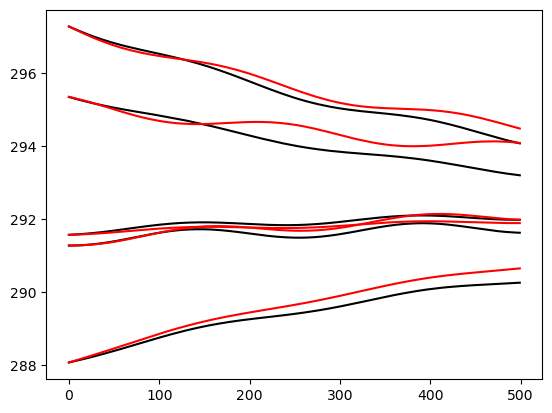

In [24]:
u = torch.from_numpy(s_test['U']).float()
sol = torch.zeros((500,5))
ic = torch.tensor(s_test['X'][0,:5])
for j in range(sol.shape[0]-1):
    if j==0:
        sol[[0],:] = ic.float()
        sol[[j+1],:] = fx_int(sol[[j],:],u[[j],:])
    else:
        sol[[j+1],:] = fx_int(sol[[j],:],u[[j],:])

plt.plot(sol.detach().numpy(),label='model', color = 'black')
plt.plot(s_test['X'][:,:5],label = 'data', color = 'red')